In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

from hloc import (
    extract_features,
    match_features,
    reconstruction,
    visualization,
    pairs_from_retrieval,
)

## Setup
In this notebook, we will run SfM reconstruction from scratch on a set of images. We choose the [South-Building dataset](https://openaccess.thecvf.com/content_cvpr_2013/html/Hane_Joint_3D_Scene_2013_CVPR_paper.html) - we will download it later. First, we define some paths.

In [2]:
images = Path("/media/guo/fs1/Hierarchical-Localization/South-Building/images/")

outputs = Path("/media/guo/fs1/Hierarchical-Localization/outputs/sfm/")
sfm_pairs = outputs / "pairs-netvlad.txt"
sfm_dir = outputs / "sfm_superpoint+superglue"

retrieval_conf = extract_features.confs["netvlad"]
feature_conf = extract_features.confs["superpoint_aachen"]
matcher_conf = match_features.confs["superglue"]

## Download the dataset
The dataset is simply a set of images. The intrinsic parameters will be extracted from the EXIF data and refined with SfM.

In [3]:
if not images.exists():
    !wget https://cvg-data.inf.ethz.ch/local-feature-evaluation-schoenberger2017/South-Building.zip -P datasets/
    !unzip -q datasets/South-Building.zip -d datasets/

## Find image pairs via image retrieval
We extract global descriptors with NetVLAD and find for each image the most similar ones. For smaller dataset we can instead use exhaustive matching via `hloc/pairs_from_exhaustive.py`, which would find $\frac{n(n-1)}{2}$ images pairs.

In [4]:
retrieval_path = extract_features.main(retrieval_conf, images, outputs)
pairs_from_retrieval.main(retrieval_path, sfm_pairs, num_matched=5)

[2024/09/10 15:48:09 hloc INFO] Extracting local features with configuration:
{'model': {'name': 'netvlad'},
 'output': 'global-feats-netvlad',
 'preprocessing': {'resize_max': 1024}}
[2024/09/10 15:48:09 hloc INFO] Found 128 images in root /media/guo/fs1/Hierarchical-Localization/South-Building/images.
[2024/09/10 15:48:09 hloc INFO] Skipping the extraction.
[2024/09/10 15:48:09 hloc INFO] Extracting image pairs from a retrieval database.
[2024/09/10 15:48:10 hloc INFO] Found 640 pairs.


## Extract and match local features

In [5]:
feature_path = extract_features.main(feature_conf, images, outputs)
match_path = match_features.main(
    matcher_conf, sfm_pairs, feature_conf["output"], outputs
)

[2024/09/10 15:48:16 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 3},
 'output': 'feats-superpoint-n4096-r1024',
 'preprocessing': {'grayscale': True, 'resize_max': 1024}}
[2024/09/10 15:48:16 hloc INFO] Found 128 images in root /media/guo/fs1/Hierarchical-Localization/South-Building/images.


Loaded SuperPoint model


100%|██████████| 128/128 [00:05<00:00, 23.44it/s]
[2024/09/10 15:48:21 hloc INFO] Finished exporting features.
[2024/09/10 15:48:21 hloc INFO] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matches-superglue'}


Loaded SuperGlue model ("outdoor" weights)


100%|██████████| 397/397 [01:47<00:00,  3.69it/s]
[2024/09/10 15:50:09 hloc INFO] Finished exporting matches.


## 3D reconstruction
Run COLMAP on the features and matches.

In [6]:
model = reconstruction.main(sfm_dir, images, sfm_pairs, feature_path, match_path)

[2024/09/10 15:50:18 hloc INFO] Creating an empty database...
[2024/09/10 15:50:18 hloc INFO] Importing images into the database...
[2024/09/10 15:50:24 hloc INFO] Importing features into the database...
100%|██████████| 128/128 [00:00<00:00, 1787.03it/s]
[2024/09/10 15:50:24 hloc INFO] Importing matches into the database...
100%|██████████| 640/640 [00:00<00:00, 2398.45it/s]
[2024/09/10 15:50:24 hloc INFO] Performing geometric verification of the matches...
I20240910 15:50:24.555886 140383027693312 misc.cc:198] 
Feature matching
I20240910 15:50:24.556525 140383634556672 sift.cc:1457] Creating SIFT CPU feature matcher
I20240910 15:50:24.556564 140383010907904 sift.cc:1457] Creating SIFT CPU feature matcher
I20240910 15:50:24.556564 140384039548672 sift.cc:1457] Creating SIFT CPU feature matcher
I20240910 15:50:24.556659 140383549748992 sift.cc:1457] Creating SIFT CPU feature matcher
I20240910 15:50:24.556780 140383532963584 sift.cc:1457] Creating SIFT CPU feature matcher
I20240910 15:5

## Visualization
We visualize some of the registered images, and color their keypoint by visibility, track length, or triangulated depth.

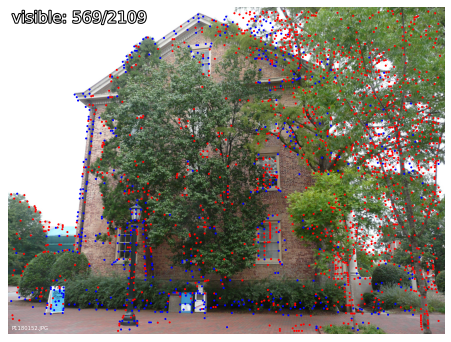

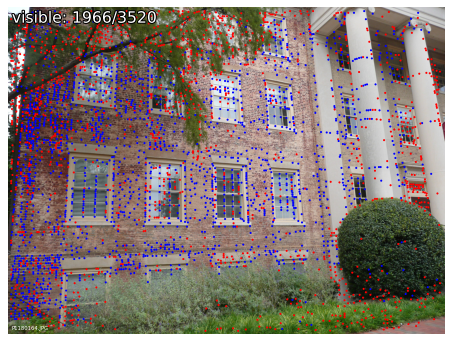

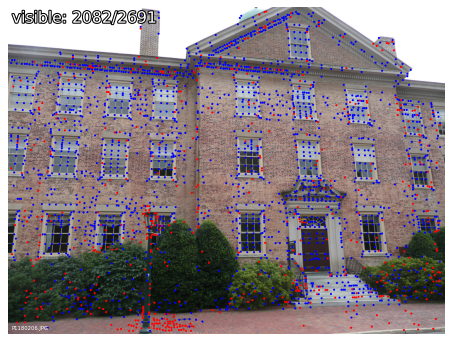

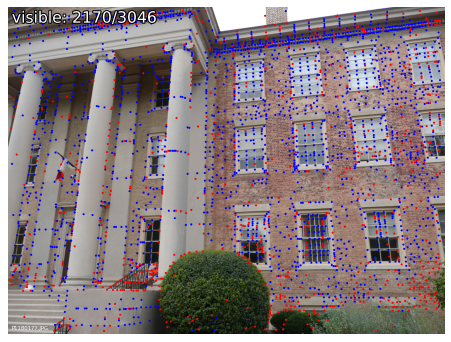

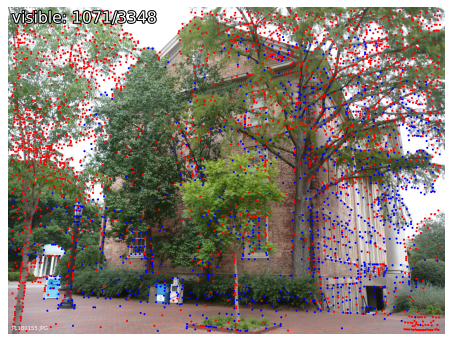

In [7]:
visualization.visualize_sfm_2d(model, images, color_by="visibility", n=5)

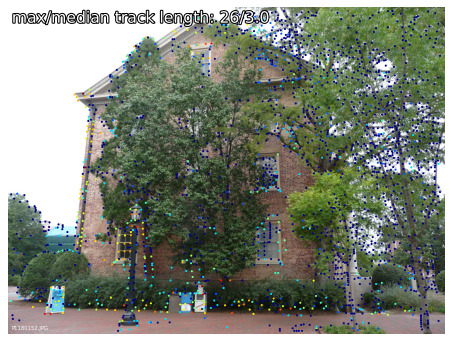

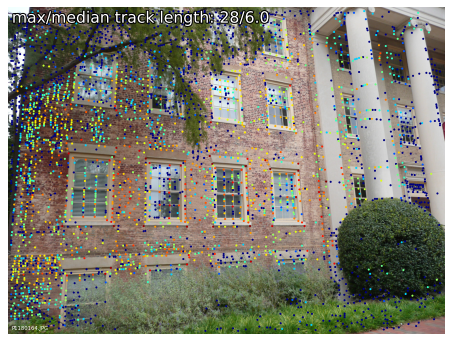

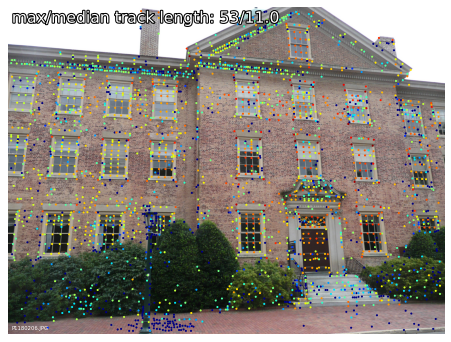

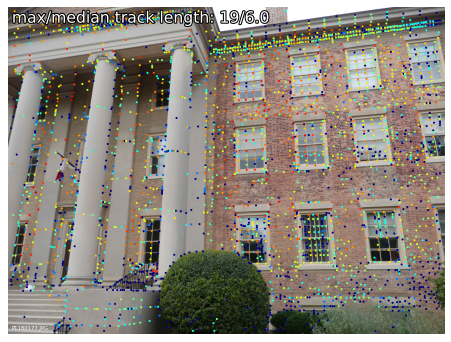

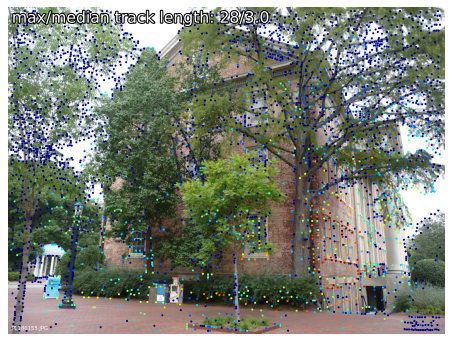

In [8]:
visualization.visualize_sfm_2d(model, images, color_by="track_length", n=5)

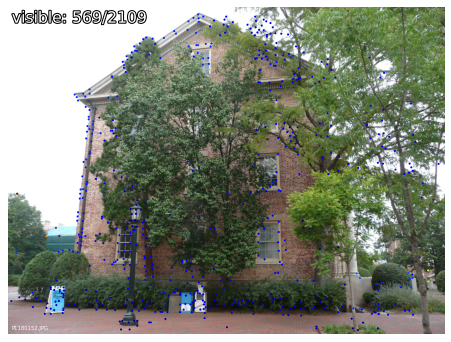

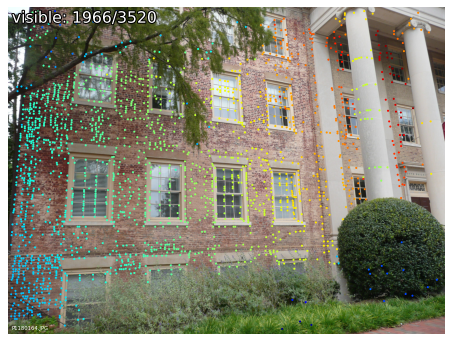

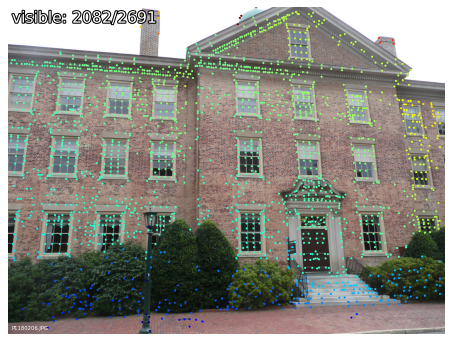

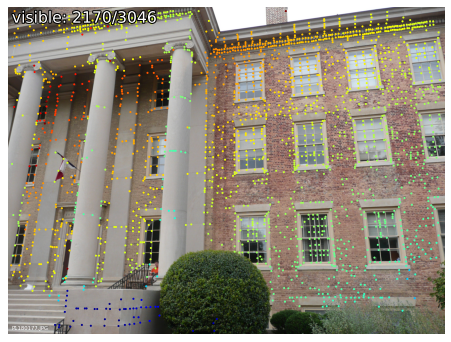

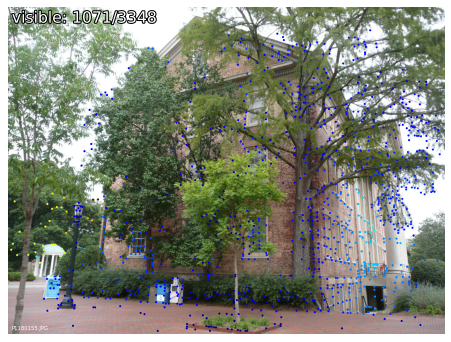

In [9]:
visualization.visualize_sfm_2d(model, images, color_by="depth", n=5)